<a href="https://colab.research.google.com/github/Sravanikurma/m1/blob/main/ris_drl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision torchaudio

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

Episode 0, SNR: 91.69, Reward: 6.534, Noise STD: 0.499
Episode 100, SNR: 63.88, Reward: 6.020, Noise STD: 0.452
Episode 200, SNR: 12.57, Reward: 3.763, Noise STD: 0.409
Episode 300, SNR: 87.27, Reward: 6.464, Noise STD: 0.370
Episode 400, SNR: 79.10, Reward: 6.324, Noise STD: 0.335
Episode 500, SNR: 46.36, Reward: 5.566, Noise STD: 0.303
Episode 600, SNR: 85.62, Reward: 6.437, Noise STD: 0.274
Episode 700, SNR: 66.59, Reward: 6.079, Noise STD: 0.248
Episode 800, SNR: 92.87, Reward: 6.553, Noise STD: 0.224
Episode 900, SNR: 84.36, Reward: 6.415, Noise STD: 0.203
Episode 1000, SNR: 76.10, Reward: 6.269, Noise STD: 0.184
Episode 1100, SNR: 62.25, Reward: 5.983, Noise STD: 0.166
Episode 1200, SNR: 67.23, Reward: 6.092, Noise STD: 0.150
Episode 1300, SNR: 61.67, Reward: 5.970, Noise STD: 0.136
Episode 1400, SNR: 85.44, Reward: 6.434, Noise STD: 0.123
Episode 1500, SNR: 92.91, Reward: 6.553, Noise STD: 0.111
Episode 1600, SNR: 74.88, Reward: 6.246, Noise STD: 0.101
Episode 1700, SNR: 78.79, 

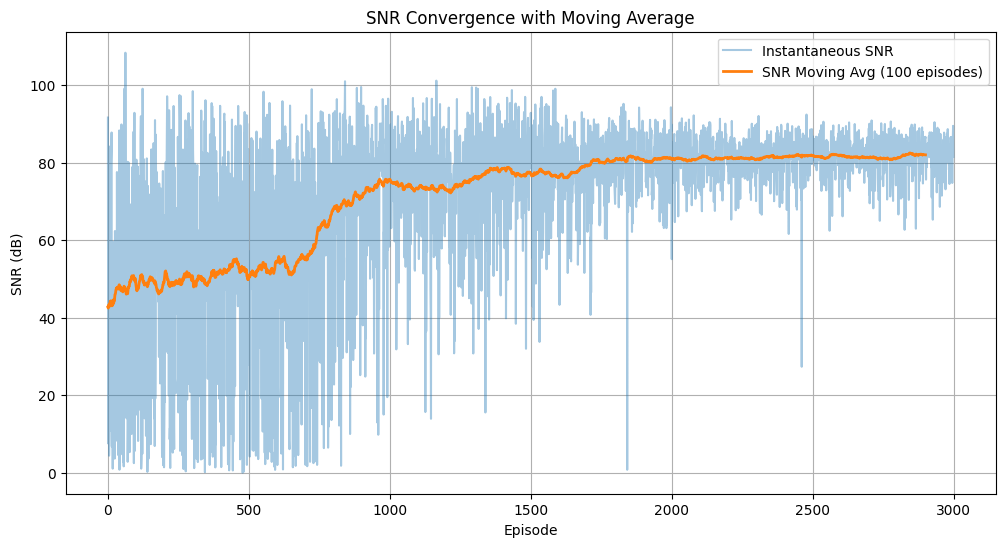

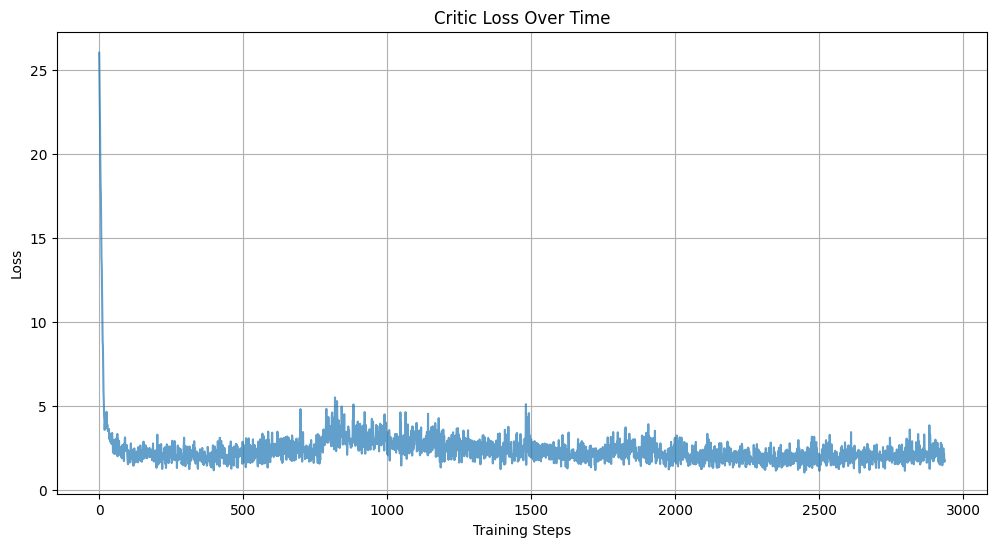

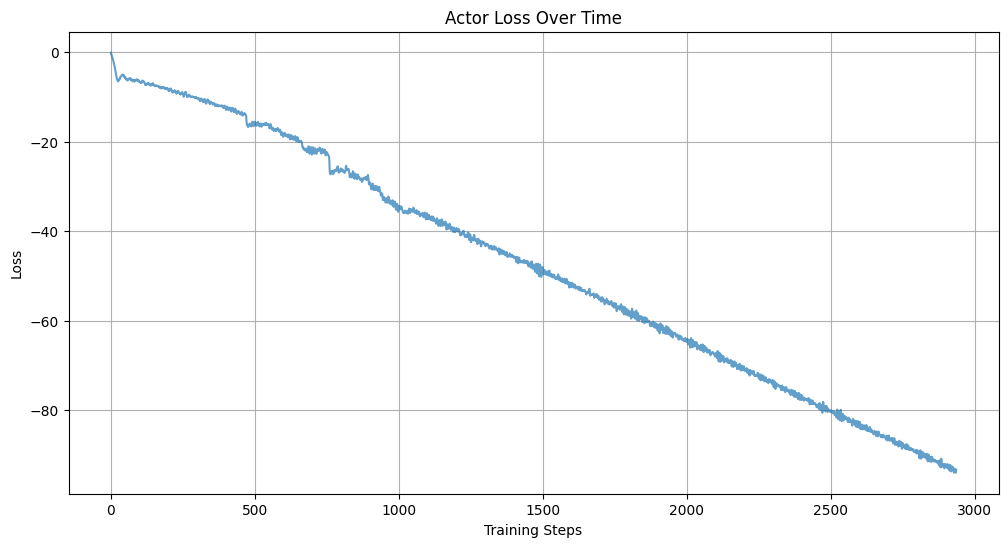

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# System Parameters
N = 4  # RIS elements
M = 2  # BS antennas
sigma2 = 0.1
P_max = 1

# Fixed channels (complex)
h_ru = (np.random.randn(1, N) + 1j * np.random.randn(1, N)) / np.sqrt(2)
H_br = (np.random.randn(N, M) + 1j * np.random.randn(N, M)) / np.sqrt(2)

def compute_snr(phases, beamforming):
    theta = np.exp(1j * phases)
    theta_diag = np.diag(theta)
    effective_channel = h_ru @ theta_diag @ H_br @ beamforming
    snr = np.abs(effective_channel) ** 2 / sigma2
    return snr.item()

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = map(np.vstack, zip(*samples))
        return torch.FloatTensor(states), torch.FloatTensor(actions), torch.FloatTensor(rewards), torch.FloatTensor(next_states)

    def __len__(self):
        return len(self.buffer)

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        output = torch.tanh(self.fc3(x))
        return output

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
state_dim = N + M
action_dim = N + M
num_episodes = 3000
batch_size = 64
gamma = 0.99
tau = 0.005
noise_std = 0.5
noise_decay = 0.999
min_noise_std = 0.05

# Initialize Networks
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim, action_dim)
target_actor = Actor(state_dim, action_dim)
target_critic = Critic(state_dim, action_dim)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer()

# Tracking variables
snr_history = []
critic_losses = []
actor_losses = []

# Training Loop
for episode in range(num_episodes):
    ris_phases = np.random.uniform(0, 2 * np.pi, N)
    bs_w = np.random.randn(M)
    bs_w = bs_w / np.linalg.norm(bs_w) * np.sqrt(P_max)
    state_np = np.concatenate([ris_phases, bs_w])
    state = torch.FloatTensor(state_np).unsqueeze(0)

    # Action from actor + exploration noise
    action = actor(state).detach().numpy()[0]
    noisy_action = action + np.random.normal(0, noise_std, size=action_dim)

    # Split action
    ris_action = np.mod((noisy_action[:N] + 1) / 2 * 2 * np.pi, 2 * np.pi)
    bs_action_raw = (noisy_action[N:] + 1) / 2 * 2 - 1
    bs_action = bs_action_raw / np.linalg.norm(bs_action_raw) * np.sqrt(P_max)

    snr = compute_snr(ris_action, bs_action.reshape(-1, 1))
    reward = np.log2(1 + snr)

    next_state_np = np.concatenate([ris_action, bs_action])
    next_state = torch.FloatTensor(next_state_np).unsqueeze(0)

    replay_buffer.push(state_np, noisy_action, [reward], next_state_np)

    # Update networks if buffer is ready
    if len(replay_buffer) >= batch_size:
        states, actions, rewards, next_states = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_actions = target_actor(next_states)
            target_q = rewards + gamma * target_critic(next_states, next_actions)

        current_q = critic(states, actions)
        critic_loss = loss_fn(current_q, target_q)
        critic_losses.append(critic_loss.item())

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = -critic(states, actor(states)).mean()
        actor_losses.append(actor_loss.item())

        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Soft target updates
        for target_param, param in zip(target_actor.parameters(), actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(target_critic.parameters(), critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    snr_history.append(snr)
    noise_std = max(noise_std * noise_decay, min_noise_std)

    if episode % 100 == 0:
        print(f"Episode {episode}, SNR: {snr:.2f}, Reward: {reward:.3f}, Noise STD: {noise_std:.3f}")

# Plot Functions
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot 1: SNR with Moving Average
plt.figure(figsize=(12,6))
plt.plot(snr_history, label='Instantaneous SNR', alpha=0.4)
plt.plot(moving_average(snr_history), label='SNR Moving Avg (100 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('SNR (dB)')
plt.title('SNR Convergence with Moving Average')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Critic Loss
plt.figure(figsize=(12,6))
plt.plot(critic_losses, label='Critic Loss', alpha=0.7)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Critic Loss Over Time')
plt.grid(True)
plt.show()

# Plot 3: Actor Loss
plt.figure(figsize=(12,6))
plt.plot(actor_losses, label='Actor Loss', alpha=0.7)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Actor Loss Over Time')
plt.grid(True)
plt.show()
